In [26]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [27]:
FILES_PATH = "/home/guillaume/pythia/code/data/"

Even though a notebook is not a viable solution for any porduction-ready code, I decided to use a notebook to implement my code and present the results for the first part of the assignement. It makes things easy to assess, it is easier to comment and discuss results as well as present.

### Import datasets

In [28]:
fixtures_data = pd.read_csv(f"{FILES_PATH}fixtures.csv", delimiter=",")
odds_data = pd.read_csv(f"{FILES_PATH}odds.csv", delimiter=",")
players_data = pd.read_csv(f"{FILES_PATH}players.csv", delimiter=",")
results_data = pd.read_csv(f"{FILES_PATH}results.csv", delimiter=",")
startingXI_data = pd.read_csv(f"{FILES_PATH}startingXI.csv", delimiter=",")
teams_data = pd.read_csv(f"{FILES_PATH}teams.csv", delimiter=",")

In [29]:
dict_datasets = {"fixture" : fixtures_data, "odds" : odds_data, "players" : players_data, "results" : results_data, "startingXI" : startingXI_data, "teams" : teams_data}

# Exploring the first season

# Data exploration and cleaning
Exploring the dataset and cleaning the data if needed

In [30]:
missing_values_dataset = {}
duplicated_values_dataset = {}

for _name, _dataset in dict_datasets.items():
    if _dataset.isnull().sum().any():
        missing_values_dataset[_name] = 1
    else:
        missing_values_dataset[_name] = 0

    if _dataset.duplicated().any():
        duplicated_values_dataset[_name] = 1
    else:
        duplicated_values_dataset[_name] = 0

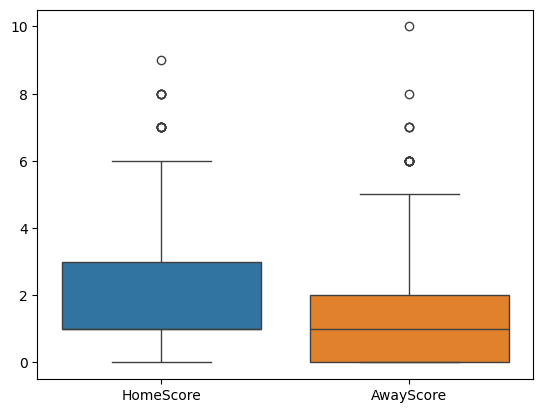

In [32]:
sns.boxplot(data=results_data[['HomeScore', 'AwayScore']])
plt.show()

## Question 1: Which team won the league in the first season?

### Merge results and team names

In [4]:
results_data = results_data.merge(teams_data, left_on="HomeTeamID", right_on = "TeamID", how="left")\
    .rename(columns = {"TeamName" : "HomeTeamName"})\
        .drop(columns="TeamID")

results_data = results_data.merge(teams_data, left_on="AwayTeamID", right_on = "TeamID", how="left")\
    .rename(columns = {"TeamName" : "AwayTeamName"})\
        .drop(columns="TeamID")

### Add the numbers of points scored for every game
- 3 for a win
- 1 for a draw
- 0 for a loss

In [6]:
def add_points(score_team1, score_team2):
    if score_team1>score_team2:
        return 3
    elif score_team1<score_team2:
        return 0
    else:
        return 1

In [7]:
results_data["HomePoints"] = results_data.apply(lambda x: add_points(x.HomeScore, x.AwayScore), axis=1)
results_data["AwayPoints"] = results_data.apply(lambda x: add_points(x.AwayScore, x.HomeScore), axis=1)

In [8]:
results_data_season1 = results_data[results_data["SeasonID"]==1]

### Create a table with every team for every weekgame as index

In [9]:
df_home_team = pd.melt(results_data_season1, id_vars = ["HomeTeamID", "HomeTeamName","Gameweek"], value_vars = ["HomePoints"], value_name="PointsScored")\
.rename(columns={"HomeTeamID":"TeamID", "HomeTeamName":"TeamName"})\
.drop(columns="variable")

df_away_team = pd.melt(results_data_season1, id_vars = ["AwayTeamID", "AwayTeamName","Gameweek"], value_vars = ["AwayPoints"], value_name="PointsScored")\
.rename(columns={"AwayTeamID":"TeamID", "AwayTeamName":"TeamName"})\
.drop(columns="variable")

In [10]:
df_all_team = pd.concat((df_home_team, df_away_team)).sort_values(["Gameweek", "TeamID"])

### Sum all the points scored and get the final table for season 1

In [11]:
df_ranking_season1 = df_all_team.groupby(["TeamID", "TeamName"]).agg(
    TotalPoints = ("PointsScored", "sum")
).sort_values(by="TotalPoints", ascending=False).reset_index()

df_ranking_season1["Ranking"] = np.arange(1, len(df_ranking_season1)+1)

In [12]:
df_ranking_season1

,TeamID,TeamName,TotalPoints,Ranking
0,15,Miami,138,1
1,8,Cincinnati,125,2
2,4,Baltimore,117,3
3,19,New York S,113,4
4,5,Boston,106,5
5,27,Seattle,105,6
6,6,Chicago B,105,7
7,21,Oakland,96,8
8,7,Chicago H,95,9
9,24,St. Louis,94,10


## Question 2: At what point in the season did that team secure their league title?

According the Premier League official website:


If any clubs finish with the same number of points, their position in the Premier League table is determined by goal difference, then the number of goals scored, then the team who collected the most points in the head-to-head matches, then who scored most away goals in the head-to-head. 

As it is impossible to predict the final goal difference, we will consider that the winner secured their title with certitude when their number of points is higher than the number of points of the 2nd plus the maximum number points left to score. 

### Calculate the number of maximum points left to score for every gameweek

In [30]:
df_all_team["MaxPointsLeft"] = df_all_team.Gameweek.max()*3 - df_all_team.Gameweek*3

### Calculate the number of total points for every team for every gameweek

In [31]:
df_all_team["CumulativePoints"] = df_all_team.sort_values(by=["Gameweek", "TeamID"]).groupby(["TeamID", "TeamName"])["PointsScored"].cumsum().values

In [32]:
df_all_team = df_all_team.merge(df_all_team[df_all_team["TeamID"]==15][["Gameweek", "CumulativePoints"]], on="Gameweek", suffixes=(("", "Winner")))

### Calculate the difference of points between the winning team for each team at every gameweek

In [33]:
df_all_team["DiffPointsWinner"] = df_all_team["CumulativePointsWinner"] - df_all_team["CumulativePoints"]
df_all_team["DiffPossiblePoints"] = df_all_team.apply(lambda x: 1 if x.DiffPointsWinner>x.MaxPointsLeft else 0, axis = 1)

### Find the first time when the 2nd of the league could not catch up with the winner

In [34]:
df_all_team["PossibleMaxPoints"] = df_all_team["CumulativePoints"]+df_all_team["MaxPointsLeft"]

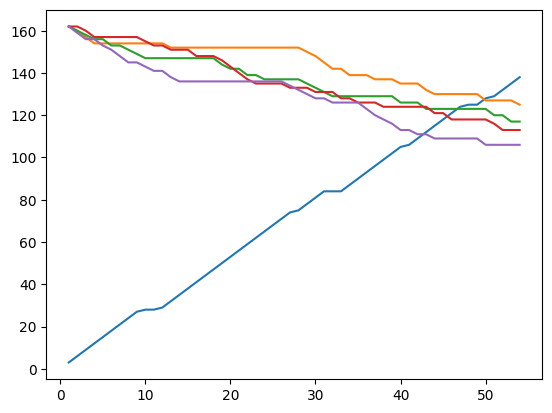

In [35]:
df_plot1 = df_all_team[df_all_team["TeamID"]==8]
df_plot2 = df_all_team[df_all_team["TeamID"]==4]
df_plot3 = df_all_team[df_all_team["TeamID"]==19]
df_plot4 = df_all_team[df_all_team["TeamID"]==5]

x = np.arange(1, len(df_plot1)+1)
plt.plot(x, df_plot1.CumulativePointsWinner)
plt.plot(x, df_plot1.PossibleMaxPoints)
plt.plot(x, df_plot2.PossibleMaxPoints)
plt.plot(x, df_plot3.PossibleMaxPoints)
plt.plot(x, df_plot4.PossibleMaxPoints)

## Question 3: What result was the biggest upset?

In [36]:
fixtures_data = pd.read_csv(f"{FILES_PATH}fixtures.csv", delimiter=",")
odds_data = pd.read_csv(f"{FILES_PATH}odds.csv", delimiter=",")
players_data = pd.read_csv(f"{FILES_PATH}players.csv", delimiter=",")
results_data = pd.read_csv(f"{FILES_PATH}results.csv", delimiter=",")
startingXI_data = pd.read_csv(f"{FILES_PATH}startingXI.csv", delimiter=",")
teams_data = pd.read_csv(f"{FILES_PATH}teams.csv", delimiter=",")

In [37]:
results_data_odds = results_data.merge(odds_data, on="MatchID", how="left")

In [38]:
def check_similar_odds(HomeOdd, DrawOdd, AwayOdd):
    if HomeOdd==DrawOdd:
        return 1
    if AwayOdd==DrawOdd:
        return 1
    if HomeOdd==DrawOdd:
        return 1
    else:
        return 0
    
results_data_odds["SimilarOdds"] = results_data_odds.apply(lambda x: check_similar_odds(x.Home, x.Draw, x.Away), axis=1)
results_data_odds[results_data_odds["SimilarOdds"]==1]

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Home,Draw,Away,SimilarOdds
176,1,13,177,8,1,13,19,1,8,1.87,4.04,4.04,1
836,2,6,837,21,2,21,14,1,10,1.94,3.89,3.89,1


In [39]:
def encode_odds(HomeOdd, DrawOdd, AwayOdd):
    odds_values = np.array([HomeOdd, DrawOdd, AwayOdd])
    return np.where(odds_values == odds_values.min())[0]

In [40]:
results_data_odds["OddEncoded"] = results_data_odds.apply(lambda x: encode_odds(x.Home, x.Draw, x.Away), axis=1)

In [41]:
def encode_results(HomeScore, AwayScore):
    if HomeScore>AwayScore:
        return 0
    elif HomeScore<AwayScore:
        return 2 
    else:
        return 1

In [42]:
results_data_odds["ResultEncoded"] = results_data_odds.apply(lambda x: encode_results(x.HomeScore, x.AwayScore), axis=1)

In [43]:
results_data_odds["Upset"] = results_data_odds.apply(lambda x: 0 if x.ResultEncoded in x.OddEncoded else 1, axis=1)

In [44]:
results_data_odds[results_data_odds["Upset"]==1]

results_data_odds["WinningOdd"] = results_data_odds.apply(lambda x: [x.Home, x.Draw, x.Away][int(x.ResultEncoded)], axis = 1)

In [45]:
results_data_odds[results_data_odds["WinningOdd"] == results_data_odds[results_data_odds["Upset"]==1]["WinningOdd"].max()]

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,Home,Draw,Away,SimilarOdds,OddEncoded,ResultEncoded,Upset,WinningOdd
1341,2,42,1342,10,1,19,15,0,32,34.88,14.79,1.07,0,[2],0,1,34.88
